# Setting up the environment

In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

     |████████████████████████████████| 3.4MB 5.1MB/s 
     |████████████████████████████████| 706kB 17.1MB/s 


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from collections import namedtuple
import cv2
from tqdm import tqdm
import random
import six
import time
import glob
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.python.training import moving_averages
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from os.path import isfile, join

In [ ]:
!nvidia-smi

Thu May 13 15:40:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Untaring Jester dataset

In [ ]:
dataset_directory = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data'
content_dir = '/content'

In [ ]:
l = os.listdir(dataset_directory)
nl = []
for s in l:
    if s.startswith('20'):
        nl.append(os.path.join(dataset_directory, s))
nl = sorted(nl)
nl

['/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-00',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-01',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-02',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-03',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-04',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-05',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-06',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-07',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v

In [ ]:
for s in tqdm(nl):
    !cp "$s" "$content_dir"

  0%|          | 0/24 [00:00<?, ?it/s]

cp: -r not specified; omitting directory '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1'


100%|██████████| 24/24 [09:24<00:00, 23.54s/it]


In [ ]:
!cat 20bn-jester-v1-??  | tar zx 

In [ ]:
len(os.listdir('/content/20bn-jester-v1'))  

148092

In [ ]:
nl = sorted(glob.glob('/content/20bn-jester-v1-**'))
for f in nl:
    !rm $f

## Working with the Dataset

#### Extracting Dataset

In [ ]:
data_dir = '/content/20bn-jester-v1'
#data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1'
num_frames = 32
fps = 12 

detector_num_frames = 32
resized_shape = (112, 112)
rescale = True

class_weights = {0:1.0, 1:3.0}
detector_name = '3D-resnet-10'
detector_input_shape = (detector_num_frames, resized_shape[0], resized_shape[1], 3)

classifier_num_frames = 32

rescale = True

classifier_name = '3D-resnet-101'
classifier_input_shape = (classifier_num_frames, resized_shape[0], resized_shape[1], 3)
idx_labels = sorted(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign', 'No gesture', 'Doing other things'])

frames_between_consecutive_activation = 8
batch_size = 32

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-train.csv', delimiter=';', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-test.csv', delimiter=';', header=None)
df_val = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-validation.csv', delimiter=';', header=None)
df_labels = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-labels.csv', delimiter=';', header=None)

selected_gestures = set(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign', 'No gesture', 'Doing other things'])

train_csv = df_train.to_dict(orient='split')['data']

train_data = {selected_label : [] for selected_label in selected_gestures}
idx_labels = list(sorted(train_data.keys()))
for data in train_csv:
    if data[1] in selected_gestures:
        train_data[data[1]].append((os.path.join(data_dir, str(data[0])),
                                    idx_labels.index(data[1])))


validation_csv = df_val.to_dict(orient='split')['data']
val_data = {selected_label : [] for selected_label in selected_gestures}
for data in validation_csv:
    if data[1] in selected_gestures:
        val_data[data[1]].append((os.path.join(data_dir, str(data[0])),
                                  idx_labels.index(data[1])))

In [ ]:
def find_len(data):
    total=0
    for key in data:
        total += len(data[key])
        print(len(data[key]))
    return total

In [ ]:
print(find_len(train_data))
print()
find_len(val_data)

4337
4259
4278
4220
9592
4084
4162
34932

536
520
533
508
1468
486
494


4545

In [ ]:
def show_vid(path = None, frames = None):
    if frames == None:
        path = os.path.join(data_dir, str(path))
        frames = sorted(os.listdir(path))
    for frame in frames:
        if path != None:
            frame = os.path.join(path, frame)
            frame = cv2.imread(frame)
            cv2_imshow(frame)
        else:
            cv2_imshow(np.array(frame) * 255.)

In [ ]:
def fn_read_frame(rescale):
    def read_frame(frame):
        frame = cv2.imread(frame)
        frame = cv2.resize(frame, resized_shape)
        if rescale: frame = frame/255.
        return frame
    return read_frame

In [ ]:
def extract_frames(path, label, num_frames = num_frames, resized_shape = resized_shape, rescale = True):
    """
    path, label --> path to video directory with all the frames and its label
    output : num_frames which are resized and rescaled if rescaled == True
    """
    frames = [os.path.join(path, frame) for frame in sorted(os.listdir(path))]
    n_frames = len(frames)

    if n_frames > num_frames:
        odd = n_frames % 2
        remove_n_frames = (n_frames - num_frames) // 2
        frames = frames[remove_n_frames : - (remove_n_frames + odd)]
    
    if n_frames < num_frames:
        odd = n_frames % 2
        add_n_frames = (num_frames - n_frames) // 2
        left_frames = frames[:add_n_frames]
        right_frames = frames[-add_n_frames - odd:]
        frames = left_frames + frames + right_frames

    read_frame = fn_read_frame(rescale)
    frames = np.array(list(map(read_frame, frames)))  
    
    if frames.shape == (0,): 
        print(path)

    oh_label = tf.one_hot(int(label), depth = len(idx_labels), dtype=tf.float32)
    
    return (frames, oh_label)

In [ ]:
a = np.arange(9).reshape(3,3).tolist()
b = np.arange(9,18).reshape(3,3).tolist()
b + a

[[9, 10, 11], [12, 13, 14], [15, 16, 17], [0, 1, 2], [3, 4, 5], [6, 7, 8]]

In [ ]:
frames, label = extract_frames(val_data[idx_labels[1]][0][0], val_data[idx_labels[1]][0][1])

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


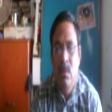

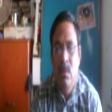

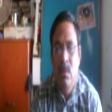

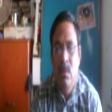

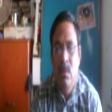

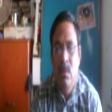

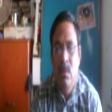

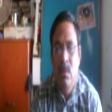

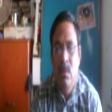

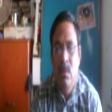

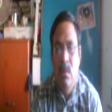

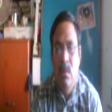

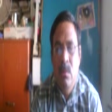

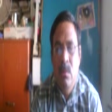

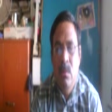

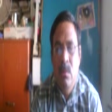

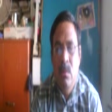

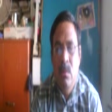

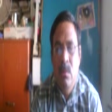

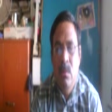

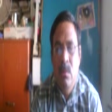

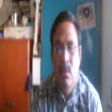

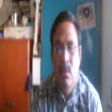

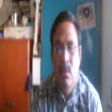

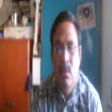

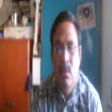

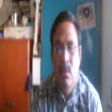

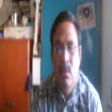

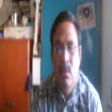

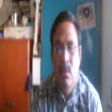

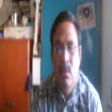

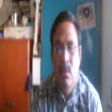

In [ ]:
print(label)
show_vid(frames = frames.tolist())

####tf.data.Dataset

In [ ]:
def get_dataset(data):
    image_paths, labels = [], []
    for key in data:
        for path, label in data[key]:
            image_paths.append(path)
            labels.append(label)
    image_paths, labels = shuffle(image_paths, labels)
    return tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
def extract_data(path, label):
    def f(path, label):
        frames, label = extract_frames(path.decode(), label)
        return (frames, label)
    return tf.numpy_function(f, [path, label], [tf.float64, tf.float32])

In [ ]:
train_ds = get_dataset(train_data)
train_ds = train_ds.map(extract_data)

train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

In [ ]:
val_ds = get_dataset(val_data)
val_ds = val_ds.map(extract_data)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

In [ ]:
i = 0
for x, y in train_ds:
    print(x.shape)
    print(y.shape)
    print(y[0])
    break

(32, 32, 112, 112, 3)
(32, 7)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)


####unziping gesture dataset


In [ ]:
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Nvidia Dataset for dynamic hand gesture recognition/nvgesture_arch/nvGesture_v1.7z.001'

Output hidden; open in https://colab.research.google.com to view.

# Model

####Config

In [ ]:
data_dir = '/content/20bn-jester-v1'
#data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1'
num_frames = 32
fps = 12 

detector_num_frames = 32
resized_shape = (112, 112)
rescale = True

class_weights = {0:1.0, 1:3.0}
detector_name = '3D-resnet-10'
detector_input_shape = (detector_num_frames, resized_shape[0], resized_shape[1], 3)

classifier_num_frames = 32

rescale = True

classifier_name = '3D-resnet-101'
classifier_input_shape = (classifier_num_frames, resized_shape[0], resized_shape[1], 3)
idx_labels = sorted(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign', 'No gesture', 'Doing other things'])

frames_between_consecutive_activation = 8
batch_size = 32

In [ ]:
idx_labels

['Doing other things',
 'No gesture',
 'Stop Sign',
 'Swiping Down',
 'Swiping Left',
 'Swiping Right',
 'Swiping Up']

#### Detector

In [ ]:
def conv_block(inputs, F, stage, strides = (2,2,2)):
    base_name = f'conv_{stage}'
    bn_axis = 4

    x = layers.Conv3D(F, (1, 1, 1), strides = strides,
                        kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv3D(F, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_1')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_2')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv3D(F, (1, 1, 1), strides = strides,
                            kernel_initializer='he_normal')(inputs)
                             
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
        

def build_model(input_dims, F, model_name):
    input_layer = layers.Input(shape=input_dims)
    x = layers.Conv3D(F, (3,3,7), strides = (1, 2, 2),
                            padding='same',
                            name = 'conv1')(input_layer)
    x = layers.BatchNormalization(axis=4)(x)
    x = layers.Activation('relu')(x)
        
    x = layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), 
                            name = 'pool1')(x)

    #x = conv_block(x, F, stage = 2)
    x = conv_block(x, F * 2, stage = 2)
    x = conv_block(x, F * 4, stage = 3)
    x = conv_block(x, F * 8, stage = 4)

    x = layers.GlobalAveragePooling3D()(x)
    pred = layers.Dense(units = 2, activation='softmax')(x)

    return tf.keras.Model(input_layer, pred, name = model_name)


In [ ]:
resnet10 = build_model(detector_input_shape, 16, detector_name)

In [ ]:
pretrained_detector_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/3d-resnet-10-bin-FineTune'
resnet10 = tf.keras.models.load_model(pretrained_detector_path)

In [ ]:
resnet10.summary()

Model: "3D-resnet-10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 112, 112 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 32, 56, 56, 1 3040        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 56, 56, 1 64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 32, 56, 56, 1 0           batch_normalization_10[0][0]     
_______________________________________________________________________________________

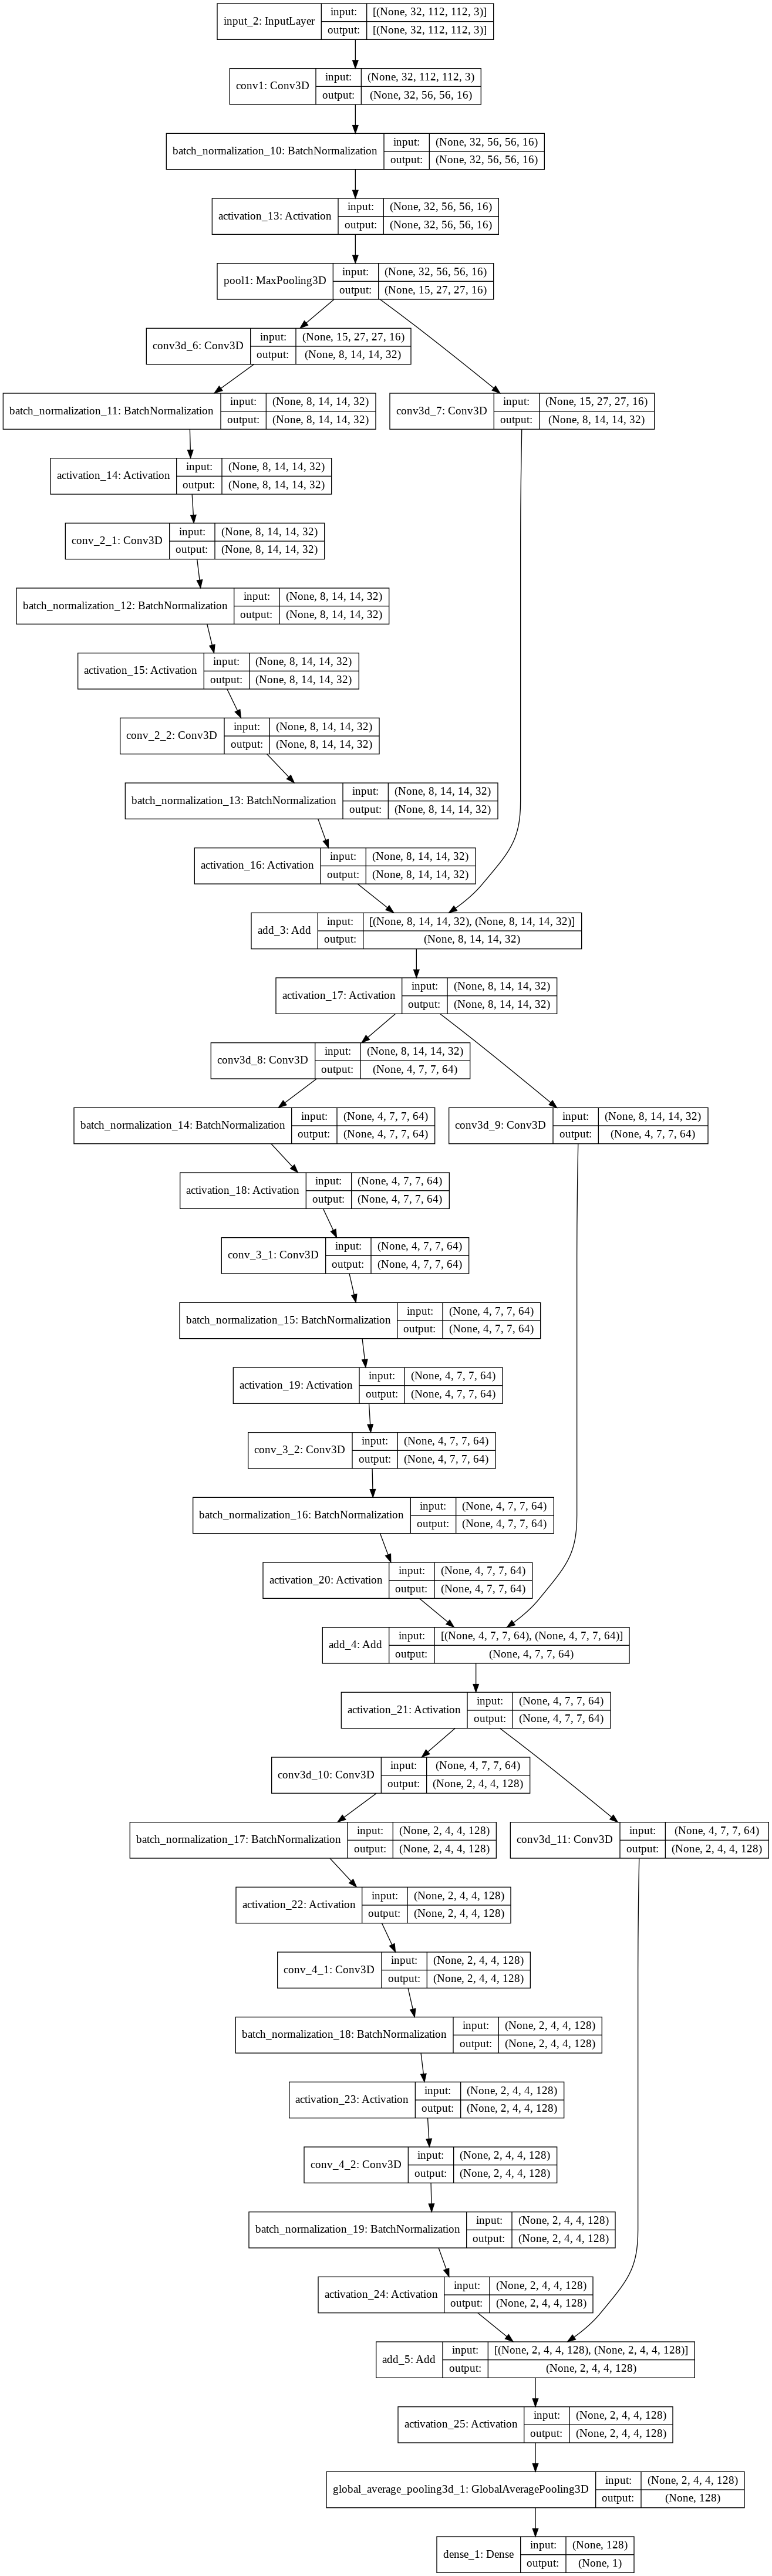

In [ ]:
plot_model(resnet10, show_shapes = True)

#### Classifier

In [ ]:
def identity_block(inputs, filters):
    F1, F2, F3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(F1, 3, padding='same')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F2, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F3, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    
    return x

def conv_block(inputs, filters, stage, strides = (2,2,2)):
    base_name = f'conv_{stage}'
    bn_axis = 4
    F1, F2, F3 = filters
    x = layers.Conv3D(F1, (1, 1, 1), strides = strides,
                        kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv3D(F2, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_1')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F3, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_2')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv3D(F3, (1, 1, 1), strides = strides,
                            kernel_initializer='he_normal')(inputs)
                             
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [ ]:

def build_model(input_dims, F, model_name):
    input_layer = layers.Input(shape=input_dims)
    x = layers.Conv3D(64, (3,3,7), strides = (1, 2, 2),
                            padding='same',
                            name = 'conv1')(input_layer)
    x = layers.BatchNormalization(axis=4)(x)
    x = layers.Activation('relu')(x)
        
    x = layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), 
                            name = 'pool1')(x)

    x = conv_block(x, [128, 128, 256], stage = 2)
    x = identity_block(x, [128, 128, 256])

    x = conv_block(x, [256, 256, 512], stage = 3)
    x = identity_block(x, [256, 256, 512])
    x = identity_block(x, [256, 256, 512])

    x = conv_block(x, [512, 512, 1024], stage = 4)
    x = identity_block(x, [512, 512, 1024])
    
    x = layers.GlobalAveragePooling3D()(x)
    pred = layers.Dense(units = len(idx_labels), activation='softmax')(x)

    return tf.keras.Model(input_layer, pred, name = model_name)


In [ ]:
resnet101 = build_model(classifier_input_shape, 64, classifier_name)

In [ ]:
model_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5'
resnet101.load_weights(model_path)

In [ ]:
#Classifier model pretrained on jester data - for 5 classes
pretrained_model_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet_Models/3d-resnet-101-7cls'
resnet101 = tf.keras.models.load_model(pretrained_model_path)
resnet101.load_weights('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5')
resnet101.summary()

Model: "3D-resnet-101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 112, 112 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 32, 56, 56, 6 12160       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 56, 56, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 56, 56, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
resnet101.evaluate(val_ds)

#### Test Model

In [ ]:
# My Data
#test_data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data'
test_data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data'
videos_paths = [join(test_data_dir, path) for path in os.listdir(test_data_dir)]
videos_paths = glob.glob('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/*.mp4')

In [ ]:
# Waka Data\
test_data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data'
videos_paths = [join(test_data_dir, path) for path in os.listdir(test_data_dir)]
videos_paths = glob.glob('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/*.mp4')[1:]

['/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022423.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022430.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022436.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022442.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022448.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Waka test data/VID_20210513_022454.mp4']

In [ ]:
videos_paths

['/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_01_44_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_01_52_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_01_56_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_02_01_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_02_07_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_02_11_Pro.mp4',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data/WIN_20210513_18_02_17_Pro.mp4']

##### Converting videos to frames

In [ ]:
!rm -r '/content/joy'

In [ ]:
def video_to_frames(input_path, output_path):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_path: Input video path.
        output_path: Output directory to save the frames.
    Returns:
        frames
    """
    try:
        os.mkdir(output_path)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_path)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_path + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))      
            break

!mkdir '/content/joy/'

for i in range(len(videos_paths)):
    #break
    print()
    input_path = videos_paths[i]
    #output_path = join(test_data_dir, f'frames/frames_{i}')
    
    output_path = f'/content/joy/frames_{i}'
    video_to_frames(input_path, output_path)


Number of frames:  179
Converting video..

Done extracting frames.
179 frames extracted
It took 4 seconds forconversion.

Number of frames:  76
Converting video..

Done extracting frames.
76 frames extracted
It took 2 seconds forconversion.

Number of frames:  86
Converting video..

Done extracting frames.
86 frames extracted
It took 2 seconds forconversion.

Number of frames:  110
Converting video..

Done extracting frames.
110 frames extracted
It took 2 seconds forconversion.

Number of frames:  107
Converting video..

Done extracting frames.
107 frames extracted
It took 3 seconds forconversion.

Number of frames:  100
Converting video..

Done extracting frames.
100 frames extracted
It took 2 seconds forconversion.

Number of frames:  139
Converting video..

Done extracting frames.
139 frames extracted
It took 4 seconds forconversion.


##### Extracting Frames data

In [ ]:
#frames_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/frames'
frames_dir = '/content/joy'
frames_paths = sorted([join(frames_dir, path) for path in os.listdir(frames_dir)])
frames_paths

['/content/joy/frames_0',
 '/content/joy/frames_1',
 '/content/joy/frames_2',
 '/content/joy/frames_3',
 '/content/joy/frames_4',
 '/content/joy/frames_5',
 '/content/joy/frames_6']

In [ ]:
def show_vid(path = None, frames = None):
    if frames == None:
        path = os.path.join(data_dir, str(path))
        frames = sorted(os.listdir(path))
    for frame in frames:
        if path != None:
            frame = os.path.join(path, frame)
            frame = cv2.imread(frame)
            cv2_imshow(frame)
        else:
            cv2_imshow(np.array(frame) * 255.)

In [ ]:
def fn_read_frame(rescale, rotate):
    def read_frame(frame):
        frame = cv2.imread(frame)
        frame = cv2.resize(frame, resized_shape)
        if rotate: frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
        if rescale: frame = frame/255.
        return frame
    return read_frame

In [ ]:
def preprocess_frames(frames):
    all_inputs = []
    n_frames = frames.shape[0]
    for i in range(0, n_frames, num_frames):
        if n_frames - i < num_frames:
            inputs = frames[n_frames - num_frames:,...]
        else: 
            inputs = frames[i:i+num_frames, ...]
        all_inputs.append(inputs)
    return np.array(all_inputs)

In [ ]:
def extract_frames(path, input_frame_rate = 30, resized_shape = resized_shape, rescale = True, 
                   rotate = True, to_show = False):
    """
    path, label --> path to video directory with all the frames and its label
    output : num_frames which are resized and rescaled if rescaled == True
    """
    raw_frames = [os.path.join(path, frame) for frame in sorted(os.listdir(path))]     
    
    frames = []
    for i in range(len(raw_frames)):
        if input_frame_rate == 30:
            if i%3 == 0 or i%5==0:
                frames.append(raw_frames[i])

    read_frame = fn_read_frame(rescale, rotate)
    frames = np.array(list(map(read_frame, frames)))

    if to_show: 
        frames = preprocess_frames(frames)
        for i in range(len(frames)):
            print(f"clip_{i}")
            show_vid(frames = frames[i].tolist())
            
        return frames
    
    return preprocess_frames(frames)  

In [ ]:
def show_predictions(path, classifier_threshold = 0.6, detector_threshold = 0.3, to_show = False):
    frames = extract_frames(path, rotate=False)
    if to_show:
        for i in range(len(frames)):
            print(f"clip_{i}")
            show_vid(frames = frames[i].tolist())
            d_pred = resnet10(np.expand_dims(frames[i], axis = 0)).numpy()
            if d_pred>detector_threshold:
                print('Detector Detected A Gesture')
            print('*' * 80)
    start = time.time()
    pred = resnet101(frames)
    print(pred)
    print(round(time.time() - start, 2))
    labels_per_clip = np.where(pred>classifier_threshold, 1, 0)
    print(labels_per_clip)
    for i, labels in enumerate(labels_per_clip):
        if sum(labels) == 1:
            print(f"clip_{i}", idx_labels[np.argmax(labels)])
        if sum(labels) > 1:
            if labels[0] == 1:
                print(f"clip_{i}", idx_labels[np.argmax(labels[1:])])
            

In [ ]:
show_predictions(frames_paths[0], to_show = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_predictions(frames_paths[1], to_show = True)

Output hidden; open in https://colab.research.google.com to view.

clip_0


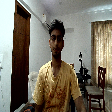

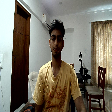

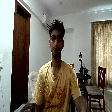

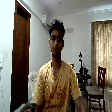

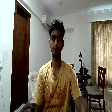

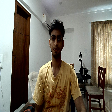

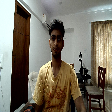

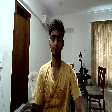

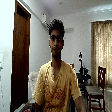

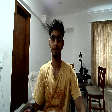

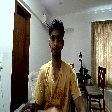

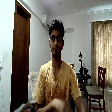

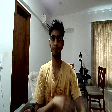

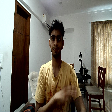

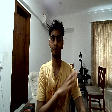

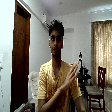

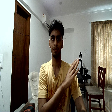

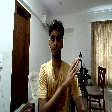

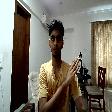

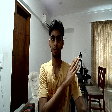

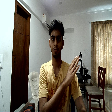

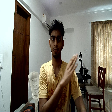

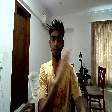

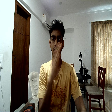

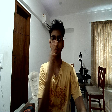

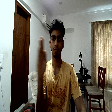

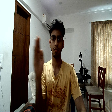

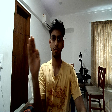

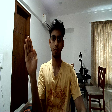

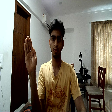

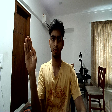

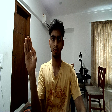

Detector Detected A Gesture
********************************************************************************
clip_1


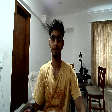

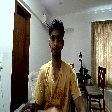

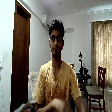

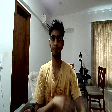

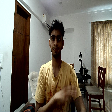

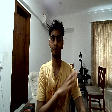

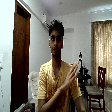

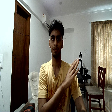

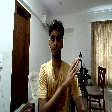

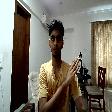

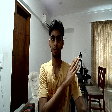

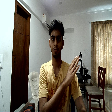

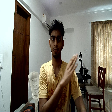

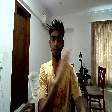

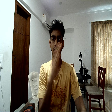

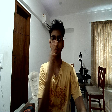

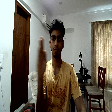

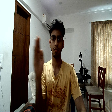

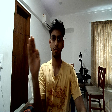

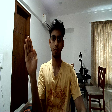

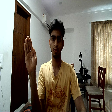

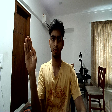

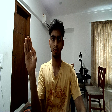

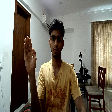

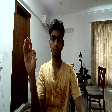

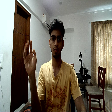

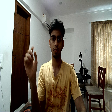

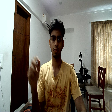

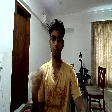

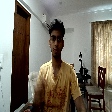

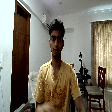

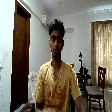

Detector Detected A Gesture
********************************************************************************
tf.Tensor(
[[0.06155367 0.0053355  0.01431988 0.00636166 0.07796337 0.7547169
  0.079749  ]
 [0.03792829 0.00333705 0.00888492 0.00492065 0.03052104 0.88433844
  0.03006959]], shape=(2, 7), dtype=float32)
0.05
[[0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
clip_0 Swiping Right
clip_1 Swiping Right


In [ ]:
show_predictions(frames_paths[2], to_show = True)

clip_0


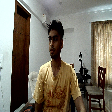

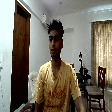

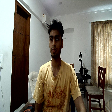

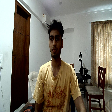

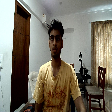

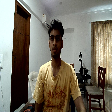

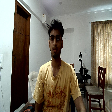

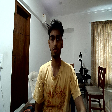

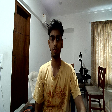

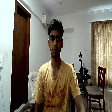

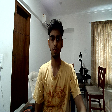

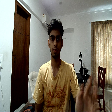

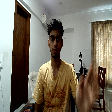

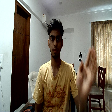

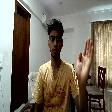

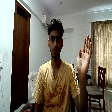

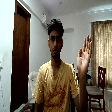

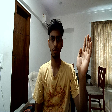

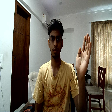

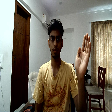

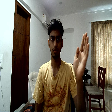

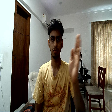

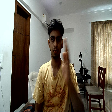

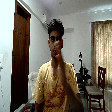

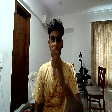

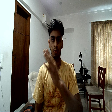

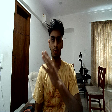

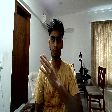

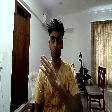

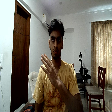

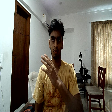

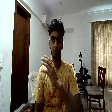

Detector Detected A Gesture
********************************************************************************
clip_1


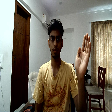

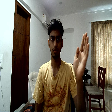

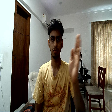

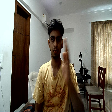

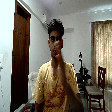

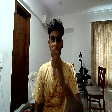

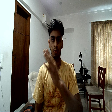

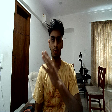

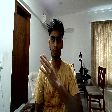

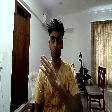

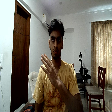

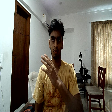

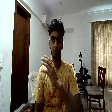

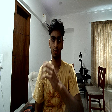

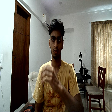

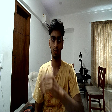

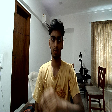

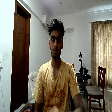

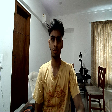

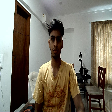

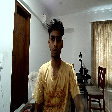

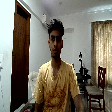

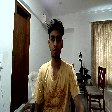

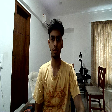

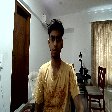

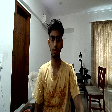

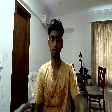

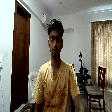

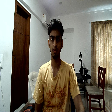

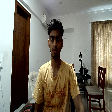

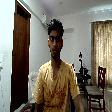

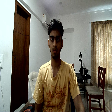

Detector Detected A Gesture
********************************************************************************
tf.Tensor(
[[0.2860269  0.01537695 0.02490626 0.01220718 0.14962353 0.4016935
  0.11016564]
 [0.49901524 0.0161001  0.02836368 0.10539101 0.11360303 0.1862143
  0.05131255]], shape=(2, 7), dtype=float32)
0.05
[[0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]]
clip_0 Swiping Right
clip_1 Doing other things


In [ ]:
show_predictions(frames_paths[3], to_show = True, classifier_threshold=0.35)

clip_0


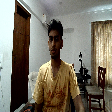

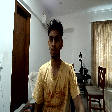

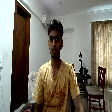

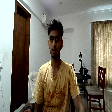

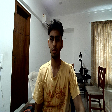

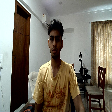

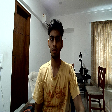

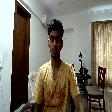

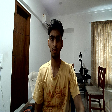

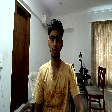

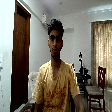

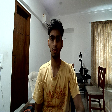

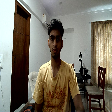

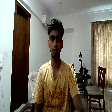

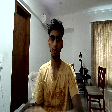

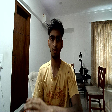

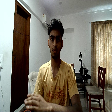

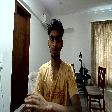

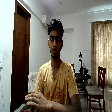

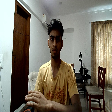

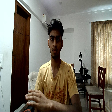

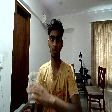

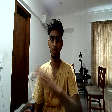

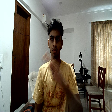

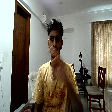

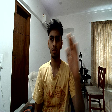

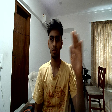

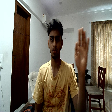

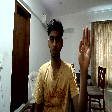

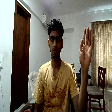

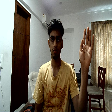

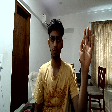

Detector Detected A Gesture
********************************************************************************
clip_1


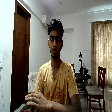

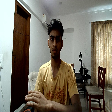

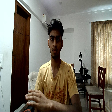

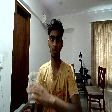

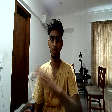

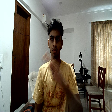

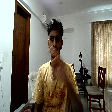

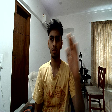

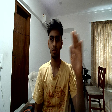

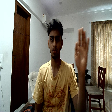

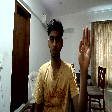

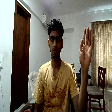

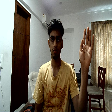

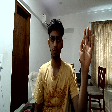

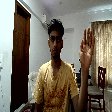

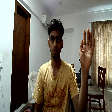

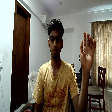

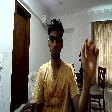

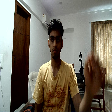

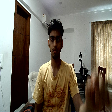

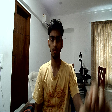

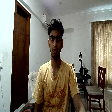

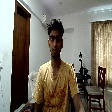

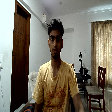

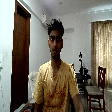

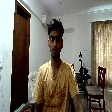

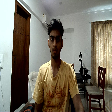

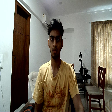

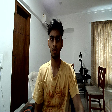

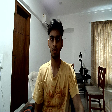

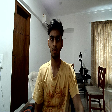

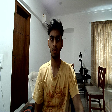

Detector Detected A Gesture
********************************************************************************
tf.Tensor(
[[0.04352653 0.00275129 0.0170668  0.01450933 0.11392862 0.02934028
  0.7788772 ]
 [0.06047239 0.00339507 0.01411339 0.01212704 0.79232764 0.03757402
  0.07999044]], shape=(2, 7), dtype=float32)
0.05
[[0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]]
clip_0 Swiping Up
clip_1 Swiping Left


In [ ]:
show_predictions(frames_paths[4], to_show = True)

clip_0


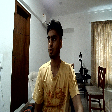

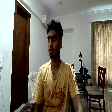

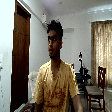

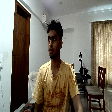

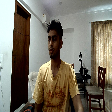

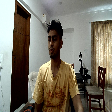

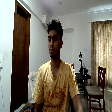

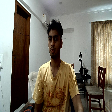

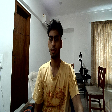

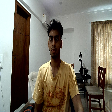

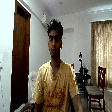

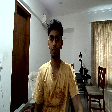

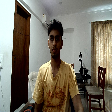

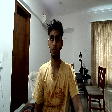

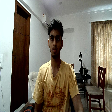

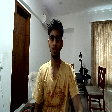

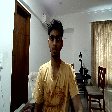

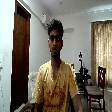

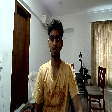

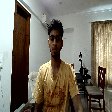

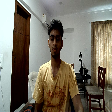

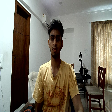

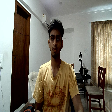

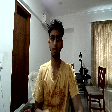

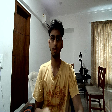

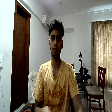

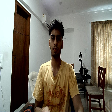

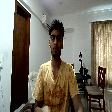

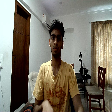

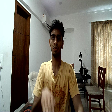

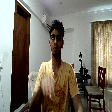

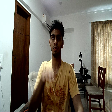

********************************************************************************
clip_1


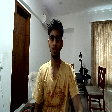

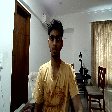

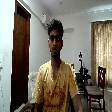

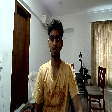

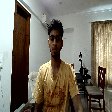

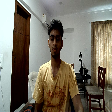

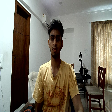

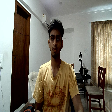

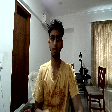

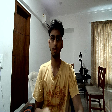

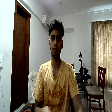

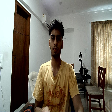

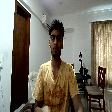

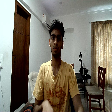

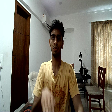

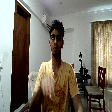

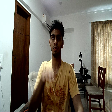

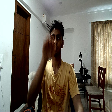

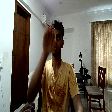

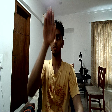

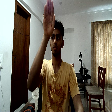

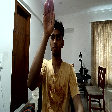

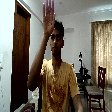

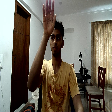

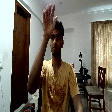

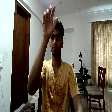

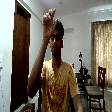

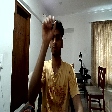

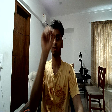

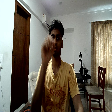

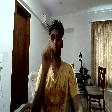

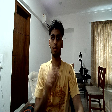

Detector Detected A Gesture
********************************************************************************
tf.Tensor(
[[3.9543182e-01 2.6192762e-02 4.4365963e-01 1.3855038e-02 3.4908347e-02
  6.0074795e-03 7.9944842e-02]
 [1.2230497e-02 6.5205793e-04 7.1822517e-03 8.8650417e-03 3.9226199e-03
  3.1456137e-03 9.6400195e-01]], shape=(2, 7), dtype=float32)
0.05
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]]
clip_1 Swiping Up


In [ ]:
show_predictions(frames_paths[5], to_show = True)

# Try with your own video

In [1]:
input_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Joys test data/webcam data' # --> should be path to a folder containing the videos you need to test model on
output_dir = '/content/joy/frames' # --> path to a folder where you want to dump all the frames extracted from a video 

In [2]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
import time
import glob
from google.colab.patches import cv2_imshow
from os.path import isfile, join

     |████████████████████████████████| 3.4MB 5.5MB/s 
     |████████████████████████████████| 706kB 33.8MB/s 


In [3]:
fps = 12 

resized_shape = (112, 112)
rescale = True

idx_labels = sorted(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign', 'No gesture', 'Doing other things'])

In [4]:
def video_to_frames(input_path, output_path):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_path: Input video path.
        output_path: Output directory to save the frames.
    Returns:
        frames
    """
    try:
        os.mkdir(output_path)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_path)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_path + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))      
            break

!mkdir -p '$output_dir'

videos_paths = [join(input_dir, path) for path in os.listdir(input_dir)]
videos_paths = glob.glob(os.path.join(input_dir,'*.mp4'))

for i in range(len(videos_paths)):
    input_path = videos_paths[i]
    output_path = os.path.join(output_dir, f'frames_{i}')
    video_to_frames(input_path, output_path)

Number of frames:  179
Converting video..

Done extracting frames.
179 frames extracted
It took 5 seconds forconversion.
Number of frames:  76
Converting video..

Done extracting frames.
76 frames extracted
It took 2 seconds forconversion.
Number of frames:  86
Converting video..

Done extracting frames.
86 frames extracted
It took 2 seconds forconversion.
Number of frames:  110
Converting video..

Done extracting frames.
110 frames extracted
It took 3 seconds forconversion.
Number of frames:  107
Converting video..

Done extracting frames.
107 frames extracted
It took 3 seconds forconversion.
Number of frames:  100
Converting video..

Done extracting frames.
100 frames extracted
It took 3 seconds forconversion.


In [5]:
def show_vid(path = None, frames = None):
    if frames == None:
        path = os.path.join(data_dir, str(path))
        frames = sorted(os.listdir(path))
    for frame in frames:
        if path != None:
            frame = os.path.join(path, frame)
            frame = cv2.imread(frame)
            cv2_imshow(frame)
        else:
            cv2_imshow(np.array(frame) * 255.)

def fn_read_frame(rescale, rotate):
    def read_frame(frame):
        frame = cv2.imread(frame)
        frame = cv2.resize(frame, resized_shape)
        if rotate: frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
        if rescale: frame = frame/255.
        return frame
    return read_frame

def preprocess_frames(frames, num_frames = 32):
    all_inputs = []
    n_frames = frames.shape[0]
    for i in range(0, n_frames, num_frames):
        if n_frames - i < num_frames:
            inputs = frames[n_frames - num_frames:,...]
        else: 
            inputs = frames[i:i+num_frames, ...]
        all_inputs.append(inputs)
    return np.array(all_inputs)

def extract_frames(path, input_frame_rate = 30, resized_shape = resized_shape, rescale = True, 
                   rotate = True, to_show = False):
    """
    path, label --> path to video directory with all the frames and its label
    output : num_frames which are resized and rescaled if rescaled == True
    """
    raw_frames = [os.path.join(path, frame) for frame in sorted(os.listdir(path))]     
    
    frames = []
    for i in range(len(raw_frames)):
        if input_frame_rate == 30:
            if i%3 == 0 or i%5==0:
                frames.append(raw_frames[i])

    read_frame = fn_read_frame(rescale, rotate)
    frames = np.array(list(map(read_frame, frames)))

    if to_show: 
        frames = preprocess_frames(frames)
        for i in range(len(frames)):
            print(f"clip_{i}")
            show_vid(frames = frames[i].tolist())
            
        return frames
    
    return preprocess_frames(frames)  

def show_predictions(path, classifier_threshold = 0.6, detector_threshold = 0.3, to_show = False):
    frames = extract_frames(path, rotate=False)
    if to_show:
        for i in range(len(frames)):
            print(f"clip_{i}")
            show_vid(frames = frames[i].tolist())
            d_pred = resnet10(np.expand_dims(frames[i], axis = 0)).numpy()
            if d_pred>detector_threshold:
                print('Detector Detected A Gesture')
            print('*' * 80)
    start = time.time()
    pred = resnet101(frames)
    #print(pred)
    #print(round(time.time() - start, 2))
    labels_per_clip = np.where(pred>classifier_threshold, 1, 0)
    #print(labels_per_clip)
    for i, labels in enumerate(labels_per_clip):
        if sum(labels) == 1:
            print(f"clip_{i}", idx_labels[np.argmax(labels)])
        if sum(labels) > 1:
            if labels[0] == 1:
                print(f"clip_{i}", idx_labels[np.argmax(labels[1:])])

In [6]:
pretrained_model_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet_Models/3d-resnet-101-7cls'
pretrained_detector_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/3d-resnet-10-bin-FineTune'

resnet10 = tf.keras.models.load_model(pretrained_detector_path)

resnet101 = tf.keras.models.load_model(pretrained_model_path)
resnet101.load_weights('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5')



In [7]:
frames_paths = sorted([join(output_dir, path) for path in os.listdir(output_dir)])
for i,frames_path in enumerate(frames_paths):
    print()
    print(f'Video : {i + 1}')
    print()
    show_predictions(frames_path, to_show = True)
